In [1]:
import torch
import torchvision

# Seed

In [2]:
seed_number = 44

torch.manual_seed(seed_number)
torch.cuda.manual_seed(seed_number)
torch.cuda.manual_seed_all(seed_number) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#np.random.seed(seed_number)
#random.seed(seed_number)

# MNIST data download

In [3]:
train_dataset = torchvision.datasets.MNIST('./data/', train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('./data/', train=False)

# load dataset

In [4]:
X      = train_dataset.data
X_test = test_dataset.data

print(X.shape)
print(X_test.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [5]:
y      = train_dataset.targets
y_test = test_dataset.targets

print(y.shape)
print(y_test.shape)

torch.Size([60000])
torch.Size([10000])


# split dataset

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=seed_number)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

torch.Size([48000, 28, 28]) torch.Size([48000])
torch.Size([12000, 28, 28]) torch.Size([12000])


# normalization

In [7]:
X_train = X_train / 255.
X_valid = X_valid / 255.
X_test  = X_test  / 255.

# data loader

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

X_train = X_train.to(device=device)
X_valid = X_valid.to(device=device)
X_test  = X_test.to(device=device)

y_train = y_train.to(device=device)
y_valid = y_valid.to(device=device)
y_test  = y_test.to(device=device)

cpu


In [9]:
train_ds = torch.utils.data.TensorDataset(X_train, y_train)
valid_ds = torch.utils.data.TensorDataset(X_valid, y_valid)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=128, shuffle=False)

# Model

In [10]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fully_connected_layer_1 = torch.nn.Linear(784, 256)
        self.fully_connected_layer_2 = torch.nn.Linear(256, 256)
        self.fully_connected_layer_3 = torch.nn.Linear(256, 64)
        self.fully_connected_layer_4 = torch.nn.Linear(64,  10)
        
    def forward(self, xb):
        xb = xb.view(-1, 784)
        
        out = self.fully_connected_layer_1(xb)
        out = torch.nn.ReLU()(out)
        
        out = self.fully_connected_layer_2(out)
        out = torch.nn.ReLU()(out)
        
        out = self.fully_connected_layer_3(out)
        out = torch.nn.ReLU()(out)
        
        out = self.fully_connected_layer_4(out)
        return out

In [11]:
model = Net().to(device)
print(model)

Net(
  (fully_connected_layer_1): Linear(in_features=784, out_features=256, bias=True)
  (fully_connected_layer_2): Linear(in_features=256, out_features=256, bias=True)
  (fully_connected_layer_3): Linear(in_features=256, out_features=64, bias=True)
  (fully_connected_layer_4): Linear(in_features=64, out_features=10, bias=True)
)


# cost function

In [12]:
criterion = torch.nn.CrossEntropyLoss()

# optimizer

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training

In [14]:
import time 

for epoch in range(10):
    start = time.time()
    train_loss, train_count = 0., 0.
    
    for xb, yb in train_loader:
        prediction = model(xb)
        loss = criterion(prediction, yb)
        train_loss += loss.item()
        train_count += len(yb)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        
    with torch.no_grad():
        valid_loss = 0
        valid_accuracy, valid_count = 0., 0.
        
        for xb, yb in valid_loader:
            prediction = model(xb)
            valid_loss += criterion(prediction, yb)
            valid_accuracy += prediction.data.max(1)[1].eq(yb.data).sum()
            valid_count += len(yb)
        
    train_loss /= train_count
    valid_loss /= valid_count    
    valid_accuracy /= valid_count
            
    print(f"======== Epoch {epoch+1} =======")
    print(f"Loss => train:{train_loss:.5f}, valid:{valid_loss:.5f}")
    print(f"Accuracy => {valid_accuracy*100:.2f}%, Elapsed time => {time.time()-start:.3f} sec")
    print("=======================================\n")
            

======== Epoch 1 =======
Loss => train:0.00318, valid:0.00156
Accuracy => 94.09%, Elapsed time => 2.473 sec

======== Epoch 2 =======
Loss => train:0.00116, valid:0.00109
Accuracy => 95.64%, Elapsed time => 2.536 sec

======== Epoch 3 =======
Loss => train:0.00078, valid:0.00098
Accuracy => 96.10%, Elapsed time => 2.733 sec

======== Epoch 4 =======
Loss => train:0.00057, valid:0.00069
Accuracy => 97.22%, Elapsed time => 2.748 sec

======== Epoch 5 =======
Loss => train:0.00041, valid:0.00073
Accuracy => 97.07%, Elapsed time => 2.818 sec

======== Epoch 6 =======
Loss => train:0.00033, valid:0.00069
Accuracy => 97.32%, Elapsed time => 2.832 sec

======== Epoch 7 =======
Loss => train:0.00027, valid:0.00074
Accuracy => 97.16%, Elapsed time => 2.819 sec

======== Epoch 8 =======
Loss => train:0.00021, valid:0.00071
Accuracy => 97.38%, Elapsed time => 2.863 sec

======== Epoch 9 =======
Loss => train:0.00015, valid:0.00112
Accuracy => 96.26%, Elapsed time => 2.752 sec

======== Epoch 10 =

# evaluation

In [15]:
prediction = model(X_test)
loss = criterion(prediction, y_test) / len(y_test)
accuracy = prediction.data.max(1)[1].eq(y_test.data).sum() / len(y_test)

print(f"loss: {loss:.5f}")
print(f"accuracy: {accuracy*100:.2f}%")

loss: 0.00001
accuracy: 97.65%


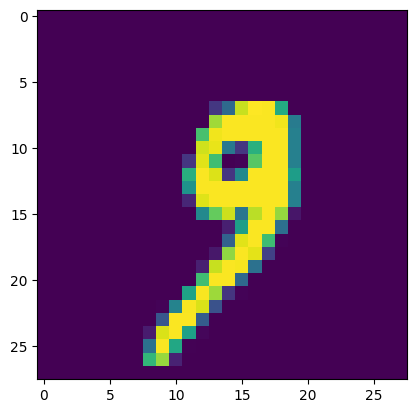

In [16]:
import matplotlib.pyplot as plt
plt.imshow(X_test[1000])

In [17]:
prediction = model(X_test[1000])
answer = prediction.data.max(1)[1]
print(answer)

tensor([9])
